# EEG DataLoader

The dimensions of the training set are as follows: 4,500 samples, 64 channels, and a time length of 795. This corresponds to 5 categories in y_train.

The dimensions of the testing set are as follows: 750 samples, 64 channels, and a time length of 795. This corresponds to 5 categories in y_test.

You can download it from this Google Drive link: [https://drive.google.com/drive/folders/1ykR-mn4d4KfFeeNrfR6UdtebsNRY8PU2?usp=sharing].
Please download the data and place it in your data_path at "./data."

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torchviz import make_dot

In [15]:
data_path = '/Users/siddhartharaovs/Downloads/CS555-Agile project Files/BCI_project/'

In [16]:
train_data = np.load(data_path + 'train_data.npy')
test_data = np.load(data_path + 'test_data.npy')
train_label = np.load(data_path + 'train_label.npy')
test_label = np.load(data_path + 'test_label.npy')

#To convert the data into PyTorch tensors
x_train_tensor = torch.Tensor(train_data)
y_train_tensor = torch.LongTensor(train_label)
x_test_tensor = torch.Tensor(test_data)
y_test_tensor = torch.LongTensor(test_label)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Setting GPU on your computer

In [18]:
train_dataset = TensorDataset(x_train_tensor.to(device), y_train_tensor.to(device)) # input data to Tensor dataloader
train_loader = DataLoader(train_dataset, batch_size=64, drop_last=True, shuffle=True) #  Batch size refers to the number of data sample
test_dataset = TensorDataset(x_test_tensor.to(device), y_test_tensor.to(device))
test_loader = DataLoader(test_dataset, batch_size=64,  drop_last=True,shuffle=False)

# Build simple Deep learning model

In [19]:
class EEGAutoencoderClassifier(nn.Module):
    def __init__(self, num_classes):
        super(EEGAutoencoderClassifier, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 795, 512), # Input dimention is 64 channel * 795 time point, and use 256 units for first NN layer
            nn.ReLU(), # Use ReLu function for NN training
            nn.Linear(512, 256), # 256 NN units to 128 units
            nn.ReLU(),
            nn.Linear(256, 128),#  128 NN units to 64 units
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128, num_classes), # num_classes is 5 ("hello,” “help me,” “stop,” “thank you,” and “yes”)
            nn.LogSoftmax(dim=1)  # Use LogSoftmax for multi-class classification
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)

        # import pdb;pdb.set_trace()
        x = self.classifier(x)
        return x

In [20]:
num_classes = 5 # setting final output class
model = EEGAutoencoderClassifier(num_classes).to(device)
criterion = nn.NLLLoss() # Use NLLLoss function to optimize
optimizer = optim.Adam(model.parameters(), lr=0.0001) # Setting parameters learning rate = 0.001

In [21]:
num_epochs = 20 # setting training epochs (Number of training iterations)
for epoch in range(num_epochs):
    model.train()
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/20, Loss: 1.5489661693572998
Epoch 2/20, Loss: 1.4713943004608154
Epoch 3/20, Loss: 1.3510487079620361
Epoch 4/20, Loss: 1.1710681915283203
Epoch 5/20, Loss: 0.9525489807128906
Epoch 6/20, Loss: 0.7050800323486328
Epoch 7/20, Loss: 0.7231748104095459
Epoch 8/20, Loss: 0.4474938213825226
Epoch 9/20, Loss: 0.5945549607276917
Epoch 10/20, Loss: 0.32907816767692566
Epoch 11/20, Loss: 0.18464191257953644
Epoch 12/20, Loss: 0.14103823900222778
Epoch 13/20, Loss: 0.21431128680706024
Epoch 14/20, Loss: 0.12420380115509033
Epoch 15/20, Loss: 0.0984446331858635
Epoch 16/20, Loss: 0.14390358328819275
Epoch 17/20, Loss: 0.04908600449562073
Epoch 18/20, Loss: 0.09123867005109787
Epoch 19/20, Loss: 0.05577555671334267
Epoch 20/20, Loss: 0.06065870448946953


In [22]:
model.eval() # Evaluate your model
correct = 0
total = 0

with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 50.99%


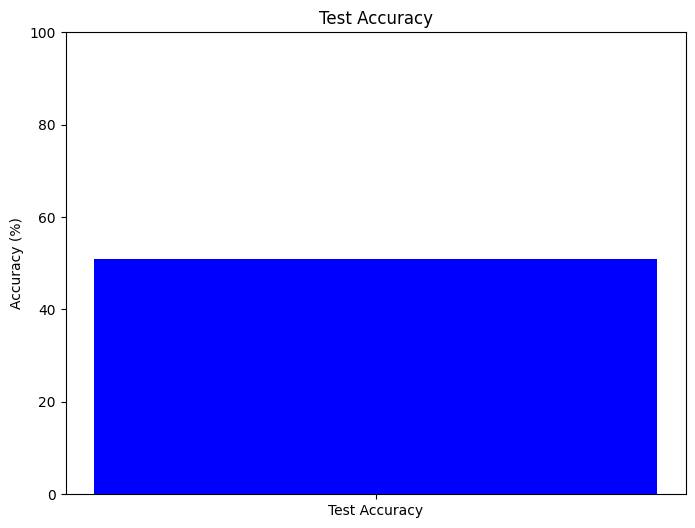

In [23]:
plt.figure(figsize=(8, 6))
plt.bar(["Test Accuracy"], [accuracy * 100], color='blue')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.ylim(0, 100)
plt.show()


In [24]:
model = EEGAutoencoderClassifier(num_classes).to(device)
dummy_input = torch.randn(1, 64 * 795).to(device)
output = model(dummy_input)
graph = make_dot(output, params=dict(model.named_parameters()))

#Save the graph
#graph.render(filename='model_graph', format='png')
# Display the graph
graph.view()

'Digraph.gv.pdf'

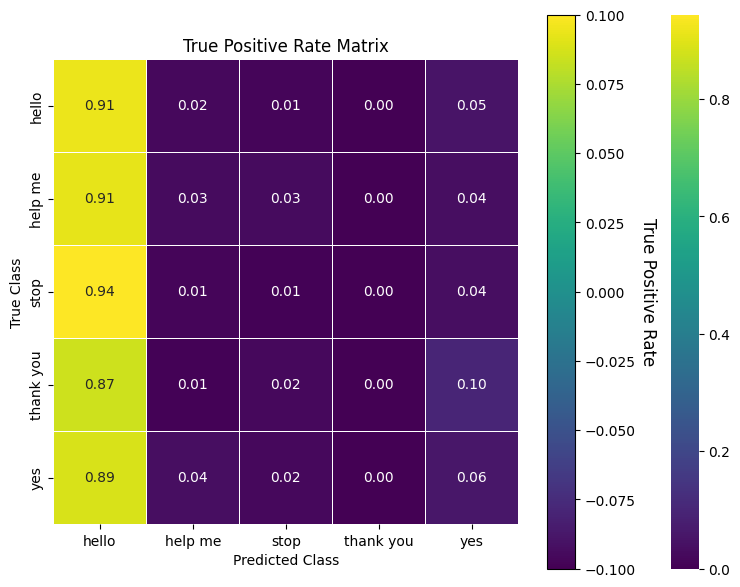

In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have defined the data loaders and model as per the provided code

# Define function to compute true positive rate matrix
def compute_true_positive_rate(model, test_loader, num_classes):
    model.eval()
    true_positive_counts = torch.zeros(num_classes, num_classes)
    class_counts = torch.zeros(num_classes)
    
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            for true_label, predicted_label in zip(labels, predicted):
                true_positive_counts[true_label][predicted_label] += 1
                class_counts[true_label] += 1

    true_positive_rate_matrix = true_positive_counts / class_counts[:, None]
    return true_positive_rate_matrix

# Instantiate model and load data as per the provided code

# Train the model
# Code for training the model as per the provided code

# Compute true positive rate matrix
true_positive_rate_matrix = compute_true_positive_rate(model, test_loader, num_classes)

# Class labels
classes = ['hello', 'help me', 'stop', 'thank you', 'yes']

# Plotting true positive rate matrix
plt.figure(figsize=(8, 6))
sns.heatmap(true_positive_rate_matrix.numpy(), annot=True, cmap='viridis', fmt=".2f", linewidths=.5, cbar=True)
plt.title('True Positive Rate Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(ticks=np.arange(5) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(5) + 0.5, labels=classes)

# Create a dummy plot for colorbar
dummy = plt.imshow([[0,0],[0,0]], cmap='viridis')
plt.colorbar(dummy).set_label('True Positive Rate', rotation=270, labelpad=15, fontsize=12)

plt.tight_layout()
plt.show()


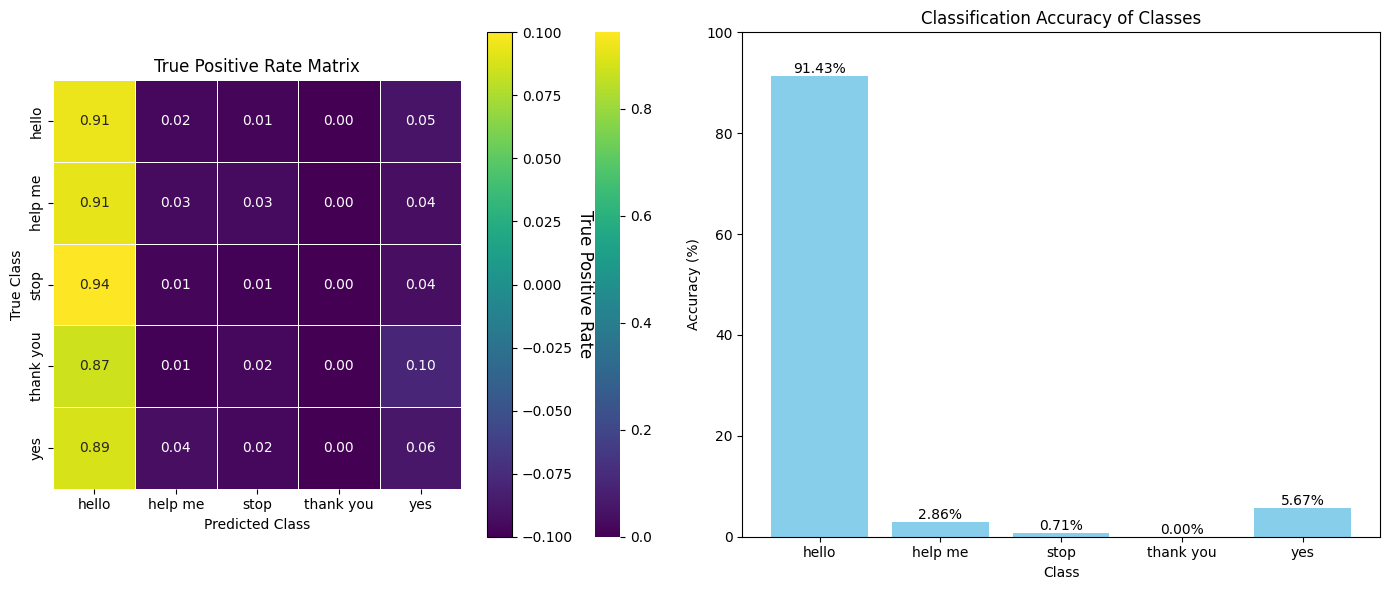

In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have defined the data loaders and model as per the provided code

# Define function to compute true positive rate matrix
def compute_true_positive_rate(model, test_loader, num_classes):
    model.eval()
    true_positive_counts = torch.zeros(num_classes, num_classes)
    class_counts = torch.zeros(num_classes)
    
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            for true_label, predicted_label in zip(labels, predicted):
                true_positive_counts[true_label][predicted_label] += 1
                class_counts[true_label] += 1

    true_positive_rate_matrix = true_positive_counts / class_counts[:, None]
    return true_positive_rate_matrix

# Define function to compute classification accuracy
def compute_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for _ in range(num_classes))
    class_total = list(0. for _ in range(num_classes))

    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    class_accuracy = [100 * class_correct[i] / class_total[i] for i in range(num_classes)]
    overall_accuracy = 100 * correct / total
    return overall_accuracy, class_accuracy

# Instantiate model and load data as per the provided code

# Train the model
# Code for training the model as per the provided code

# Compute true positive rate matrix
true_positive_rate_matrix = compute_true_positive_rate(model, test_loader, num_classes)

# Compute classification accuracy
overall_accuracy, class_accuracy = compute_accuracy(model, test_loader)

# Class labels
classes = ['hello', 'help me', 'stop', 'thank you', 'yes']

# Plotting true positive rate matrix
plt.figure(figsize=(14, 6))

# Plotting true positive rate matrix
plt.subplot(1, 2, 1)
sns.heatmap(true_positive_rate_matrix.numpy(), annot=True, cmap='viridis', fmt=".2f", linewidths=.5, cbar=True)
plt.title('True Positive Rate Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(ticks=np.arange(5) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(5) + 0.5, labels=classes)

# Create a dummy plot for colorbar
dummy = plt.imshow([[0,0],[0,0]], cmap='viridis')
plt.colorbar(dummy).set_label('True Positive Rate', rotation=270, labelpad=15, fontsize=12)

# Plotting classification accuracy
plt.subplot(1, 2, 2)
plt.bar(classes, class_accuracy, color='skyblue')
plt.title('Classification Accuracy of Classes')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

for i, acc in enumerate(class_accuracy):
    plt.text(i, acc, f'{acc:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have defined the data loaders and model as per the provided code

# Define function to create the model
def create_model(num_classes):
    model = EEGAutoencoderClassifier(num_classes).to(device) 
    return model

# Define function to train the model
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader: 
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

# Define function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for _ in range(num_classes))
    class_total = list(0. for _ in range(num_classes))

    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    overall_accuracy = 100 * correct / total
    return overall_accuracy, class_accuracy

# Instantiate model and load data as per the provided code

# Train the model
model = create_model(num_classes)
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)

# Compute true positive rate matrix
true_positive_rate_matrix = compute_true_positive_rate(model, test_loader, num_classes)

# Compute classification accuracy
overall_accuracy, class_accuracy = evaluate_model(model, test_loader)

# Class labels
classes = ['hello', 'help me', 'stop', 'thank you', 'yes']

# Plotting true positive rate matrix
plt.figure(figsize=(14, 6))

# Plotting true positive rate matrix
plt.subplot(1, 2, 1)
sns.heatmap(true_positive_rate_matrix.numpy(), annot=True, cmap='viridis', fmt=".2f", linewidths=.5, cbar=True)
plt.title('True Positive Rate Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(ticks=np.arange(5) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(5) + 0.5, labels=classes)

# Create a dummy plot for colorbar
dummy = plt.imshow([[0,0],[0,0]], cmap='viridis')
plt.colorbar(dummy).set_label('True Positive Rate', rotation=270, labelpad=15, fontsize=12)

# Plotting classification accuracy
plt.subplot(1, 2, 2)
plt.bar(classes, class_accuracy, color='skyblue')
plt.title('Classification Accuracy of Classes')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

for i, acc in enumerate(class_accuracy):
    plt.text(i, acc, f'{acc:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Epoch 1/20, Loss: 1.6147412061691284
Epoch 2/20, Loss: 1.5932185649871826
Epoch 3/20, Loss: 1.6058589220046997
Epoch 4/20, Loss: 1.6011806726455688
